# < Transformer >

https://tutorials.pytorch.kr/beginner/transformer_tutorial.html

Vaswani, Ashish, et al. "Attention is all you need." Advances in neural information processing systems 30 (2017).
(https://arxiv.org/pdf/1706.03762.pdf)

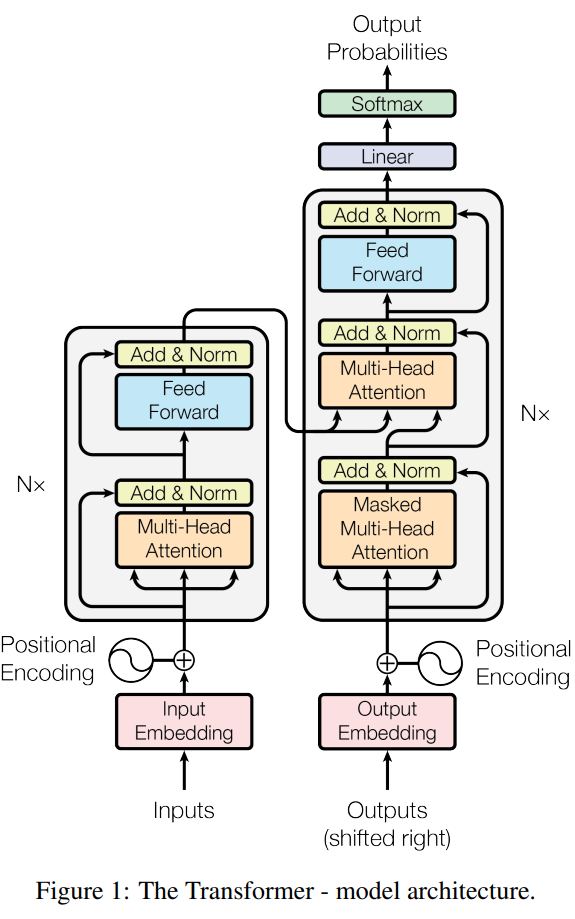

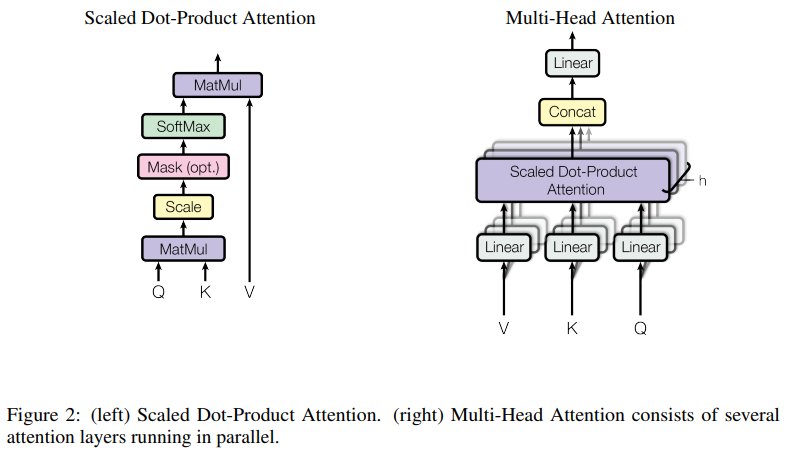

## - Import Libraries

In [1]:
import math
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

## - Make a Transformer Model

In [ ]:

class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output


def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

### - Positional Encoding

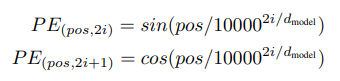

In [2]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

## - Prepare the Dataset

### - Install the torchdata Library

In [3]:
!pip install torchdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### - Make Batch Iterator

In [4]:
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
    """Converts raw text into a flat Tensor."""
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

# train_iter was "consumed" by the process of building the vocab,
# so we have to create it again
train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def batchify(data: Tensor, bsz: int) -> Tensor:
    """Divides the data into bsz separate sequences, removing extra elements
    that wouldn't cleanly fit.

    Args:
        data: Tensor, shape [N]
        bsz: int, batch size

    Returns:
        Tensor of shape [N // bsz, bsz]
    """
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)  # shape [seq_len, batch_size]
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

### - Make Get_Batch for Input-Target Pair Sequence

In [5]:
bptt = 35
def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    """
    Args:
        source: Tensor, shape [full_seq_len, batch_size]
        i: int

    Returns:
        tuple (data, target), where data has shape [seq_len, batch_size] and
        target has shape [seq_len * batch_size]
    """
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

## - Set the Parameters

In [6]:
ntokens = len(vocab) # 단어 사전(어휘집)의 크기
emsize = 200 # 임베딩 차원
d_hid = 200 # nn.TransformerEncoder 에서 피드포워드 네트워크(feedforward network) 모델의 차원
nlayers = 2 # nn.TransformerEncoder 내부의 nn.TransformerEncoderLayer 개수
nhead = 2 # nn.MultiheadAttention의 헤드 개수
dropout = 0.2 # 드랍아웃(dropout) 확률
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)

## - Training

### - Make a Training function

In [7]:
import copy
import time

criterion = nn.CrossEntropyLoss()
lr = 5.0  # 학습률(learning rate)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train(model: nn.Module) -> None:
    model.train()  # 학습 모드 시작
    total_loss = 0.
    log_interval = 200
    start_time = time.time()
    src_mask = generate_square_subsequent_mask(bptt).to(device)

    num_batches = len(train_data) // bptt
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        seq_len = data.size(0)
        if seq_len != bptt:  # 마지막 배치에만 적용
            src_mask = src_mask[:seq_len, :seq_len]
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)                 ## For prevent the gradient exploding
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()

### - Make a Evaluate function

In [ ]:

def evaluate(model: nn.Module, eval_data: Tensor) -> float:
    model.eval()  # 평가 모드 시작
    total_loss = 0.
    src_mask = generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, bptt):
            data, targets = get_batch(eval_data, i)
            seq_len = data.size(0)
            if seq_len != bptt:
                src_mask = src_mask[:seq_len, :seq_len]
            output = model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += seq_len * criterion(output_flat, targets).item()
    return total_loss / (len(eval_data) - 1)

### Do It!

In [8]:
best_val_loss = float('inf')
epochs = 3
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model)
    val_loss = evaluate(model, val_data)
    val_ppl = math.exp(val_loss)
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
          f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)

    scheduler.step()

| epoch   1 |   200/ 2928 batches | lr 5.00 | ms/batch 30.53 | loss  8.20 | ppl  3651.77
| epoch   1 |   400/ 2928 batches | lr 5.00 | ms/batch 14.91 | loss  6.89 | ppl   985.63
| epoch   1 |   600/ 2928 batches | lr 5.00 | ms/batch 15.15 | loss  6.45 | ppl   630.54
| epoch   1 |   800/ 2928 batches | lr 5.00 | ms/batch 14.80 | loss  6.30 | ppl   546.84
| epoch   1 |  1000/ 2928 batches | lr 5.00 | ms/batch 14.86 | loss  6.19 | ppl   486.45
| epoch   1 |  1200/ 2928 batches | lr 5.00 | ms/batch 14.94 | loss  6.16 | ppl   473.91
| epoch   1 |  1400/ 2928 batches | lr 5.00 | ms/batch 15.31 | loss  6.11 | ppl   452.10
| epoch   1 |  1600/ 2928 batches | lr 5.00 | ms/batch 14.99 | loss  6.11 | ppl   449.27
| epoch   1 |  1800/ 2928 batches | lr 5.00 | ms/batch 15.11 | loss  6.03 | ppl   414.64
| epoch   1 |  2000/ 2928 batches | lr 5.00 | ms/batch 15.08 | loss  6.03 | ppl   414.48
| epoch   1 |  2200/ 2928 batches | lr 5.00 | ms/batch 15.53 | loss  5.90 | ppl   364.14
| epoch   1 |  2400/ 

### - Evaluation

In [9]:
test_loss = evaluate(best_model, test_data)
test_ppl = math.exp(test_loss)
print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | '
      f'test ppl {test_ppl:8.2f}')
print('=' * 89)


| End of training | test loss  5.49 | test ppl   243.02


### - Perplexity (PPL, Lower is better)

$$PPL(W)=P(w_{1}, w_{2}, w_{3}, ... , w_{N})^{-\frac{1}{N}}=\sqrt[N]{\frac{1}{P(w_{1}, w_{2}, w_{3}, ... , w_{N})}}$$


$$PPL(W)=\sqrt[N]{\frac{1}{P(w_{1}, w_{2}, w_{3}, ... , w_{N})}}=\sqrt[N]{\frac{1}{\prod_{i=1}^{N}P(w_{i}| w_{1}, w_{2}, ... , w_{i-1})}}$$


$$PPL(W)=\sqrt[N]{\frac{1}{\prod_{i=1}^{N}P(w_{i}| w_{i-1})}}$$